[*********************100%***********************]  1 of 1 completed
/var/folders/yz/7szystj11p33mq6mw_djrn8h0000gn/T/ipykernel_65648/2426797850.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Buy'] = 0


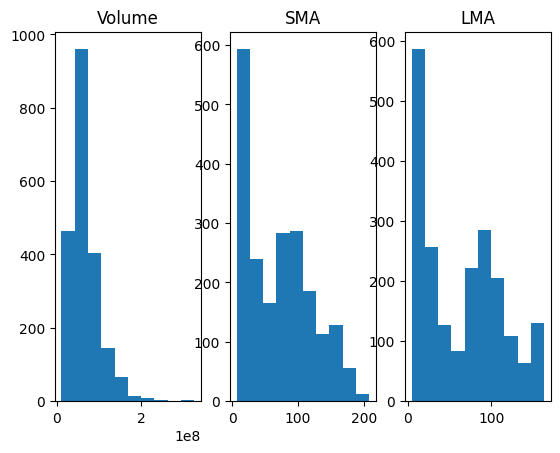

col_0    0  1
Buy          
0      373  4
1       36  0


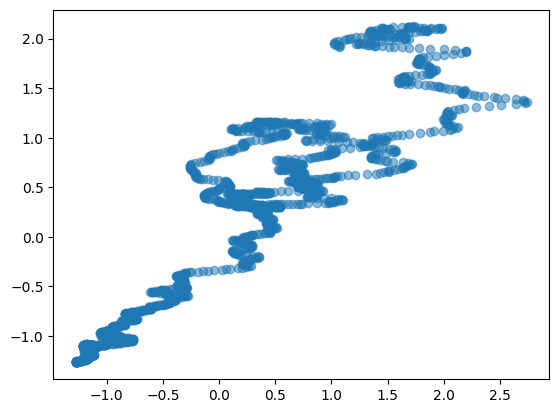

[[ 3.45096693e-01 -1.26815460e+00 -1.25822230e+00]
 [ 1.71528650e+00 -1.25954418e+00 -1.25754182e+00]
 [-2.56317688e-02 -1.24292129e+00 -1.25607402e+00]
 [-1.20390956e+00 -1.22984620e+00 -1.25311920e+00]
 [-7.14314521e-01 -1.23160017e+00 -1.25021244e+00]
 [-9.25198250e-02 -1.20457302e+00 -1.24521189e+00]
 [-1.14459503e+00 -1.20951604e+00 -1.22114279e+00]
 [-6.67041617e-01 -1.20704453e+00 -1.22032022e+00]
 [ 1.48042125e+00 -1.18216998e+00 -1.21415740e+00]
 [-3.03292794e-03 -1.13963609e+00 -1.20155613e+00]
 [ 8.59885343e-01 -1.11866812e+00 -1.19693054e+00]
 [-4.58447666e-01 -1.20246027e+00 -1.15153672e+00]
 [-1.37563926e-02 -1.20086575e+00 -1.15109979e+00]
 [ 2.90138126e+00 -1.17698778e+00 -1.14907116e+00]
 [ 1.44105735e+00 -1.18097409e+00 -1.14231010e+00]
 [-1.38219241e-01 -1.17176572e+00 -1.13800179e+00]
 [ 1.53020876e+00 -1.16905503e+00 -1.13743667e+00]
 [ 1.35249890e-01 -1.13082635e+00 -1.11999509e+00]
 [-6.03613063e-02 -1.15402666e+00 -1.10951434e+00]
 [-6.68769484e-01 -1.15829200e+

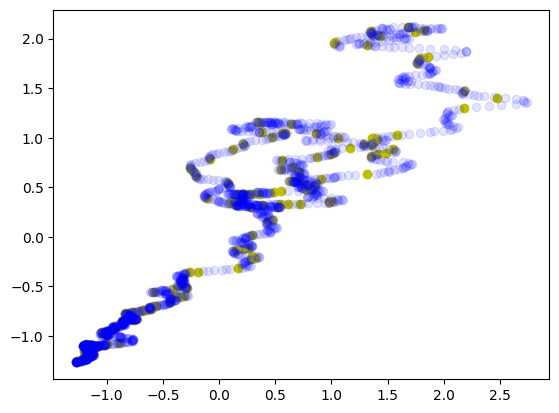

/var/folders/yz/7szystj11p33mq6mw_djrn8h0000gn/T/ipykernel_65648/2426797850.py:81: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_buy[:,0],X_buy[:,1], X_buy[:,2], c='green', cmap='coolwarm', alpha=0.7)
/var/folders/yz/7szystj11p33mq6mw_djrn8h0000gn/T/ipykernel_65648/2426797850.py:82: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_not_buy[:,0],X_not_buy[:,1], X_not_buy[:,2], c='blue', cmap='coolwarm', alpha=0.7)


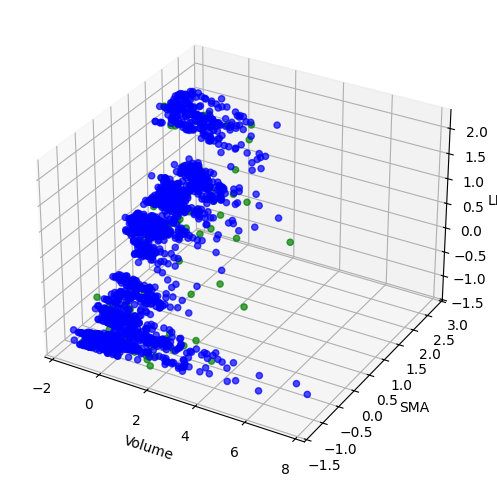

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, precision_score, recall_score

def download_stock_data(symbol, start='2016-01-01', end='2025-01-01'):
    stock = yf.download(symbol, start=start, end=end)
    return stock
def stock_add_indicator(df, sma, lma):
    df['SMA'] = df.Close.rolling(window=sma).mean()
    df['LMA'] = df.Close.rolling(window=lma).mean()
    return df
def stock_buy_sell(df, target_price_per, stop_loss_per, holding_period):
    df['Buy'] = 0
    for i in range(len(df) - holding_period):
        current_price = df[('Open', 'AMD')].iloc[i]
        for j in range(holding_period):
            if i+j>=len(df):
                break
            max_price_gain = df[('High', 'AMD')].iloc[i+j] - current_price
            max_price_lose = current_price - df[('Low', 'AMD')].iloc[i+j]
            if max_price_lose >= current_price * stop_loss_per:
                df.at[df.index[i], 'Buy'] = 0
                break
            if max_price_gain >= current_price * target_price_per:
                df.at[df.index[i], 'Buy'] = 1
                break
    return df

# Get a cleaned dataframe
df = download_stock_data('AMD').reset_index()
df = stock_add_indicator(df,5,200)
df_cleaned = df.dropna()
df_cleaned = stock_buy_sell(df_cleaned,0.01,0.003,5)
y = df_cleaned['Buy']
# Get features for volume, sma, lma
X = df_cleaned.iloc[:,5:-1]
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
fig, ax = plt.subplots(1,3)
ax[0].hist(X['Volume'])
ax[0].set_title('Volume')
ax[1].hist(X['SMA'])
ax[1].set_title('SMA')
ax[2].hist(X['LMA'])
ax[2].set_title('LMA')
plt.show()
plt.close()
# Get test and train set
x_train, x_test, y_train, y_test = train_test_split(X_scaled,y,train_size=0.8, test_size=0.2, random_state=10)
# Using a LogisticRegression model to get Classifications (buy signal)
lr = KNeighborsClassifier().fit(x_train,y_train)
y_pred = lr.predict(x_test)
corr_table = pd.crosstab(y_test, y_pred)
print(corr_table)
#print(f'recall score is: {recall_score(y_test, y_pred)}')
#print(f'precision score is: {precision_score(y_test, y_pred)}')
plt.scatter(X_scaled[:,1], X_scaled[:,2], alpha = 0.5)
plt.show()
plt.close()
X_buy = df_cleaned.iloc[:,5:-1][df_cleaned.Buy == 1]
X_not_buy = df_cleaned.iloc[:,5:-1][df_cleaned.Buy == 0]
X_buy = scaler.transform(X_buy)
X_not_buy = scaler.transform(X_not_buy)
print(X_buy)
plt.scatter(X_buy[:,1], X_buy[:,2], color = 'y', alpha=1)
plt.scatter(X_not_buy[:,1], X_not_buy[:,2], color = 'b', alpha=.1)
plt.show()
plt.close()

#create 3d scatter plot to see if there are clusters
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X_buy[:,0],X_buy[:,1], X_buy[:,2], c='green', cmap='coolwarm', alpha=0.7)
ax.scatter(X_not_buy[:,0],X_not_buy[:,1], X_not_buy[:,2], c='blue', cmap='coolwarm', alpha=0.7)
ax.set_xlabel('Volume')
ax.set_ylabel('SMA')
ax.set_zlabel('LMA')
plt.show()